## Fermi Raw Data

Visualizing the galactic center excess data from Fermi-LAT

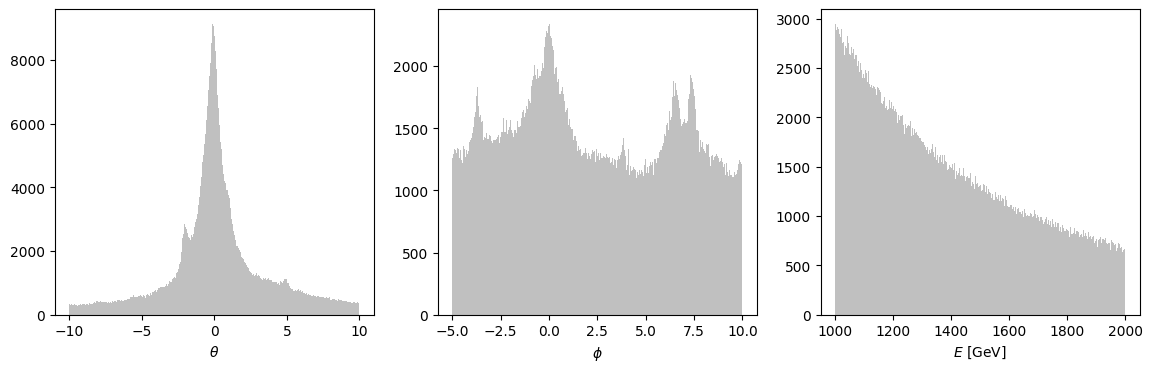

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from DynGenModels.datamodules.fermi.datasets import FermiDataset
from DynGenModels.datamodules.fermi.configs import FermiGCE_Configs 

configs = FermiGCE_Configs(cuts = {'theta': [-10., 10.], 'phi': [-5., 10.], 'energy': [1000, 2000]})
fermi = FermiDataset(configs)

# #...plot data:

from utils import results_plots, results_2D_plots

results_plots(fermi.target, bins=300)
results_2D_plots(fermi.target, bins=300)

# Normalizing flow (MAF)
We train a good old MAF with rational quadratic spline (RQS) transforms

### 1. Training

In [ ]:
#...provide the configuration parameters, overwritE the default ones if needed:

from DynGenModels.configs.fermi_configs import FermiGCE_MAF_RQS_NormFlow as Configs

configs = Configs(# data params:
                 DATA = 'FermiGCE',
                 dataset = '../../data/fermi/fermi_data_galactic_coord.npy',
                 features = ['theta', 'phi', 'energy'],
                 preprocess = ['normalize', 'logit_transform', 'standardize'],
                 cuts = {'theta': [-10., 10.], 'phi': [-5., 10.], 'energy': [1000, 2000]},
                 data_split_fracs = [0.8, 0.2, 0.0],
                 # training params:
                 DEVICE = 'cuda:3',
                 EPOCHS = 100,
                 batch_size = 15000,
                 print_epochs = 20,
                 early_stopping = 100,
                 min_epochs = 1000,
                 lr = 1e-4,
                 optimizer = 'Adam',
                 seed = 12345,
                 # flow model params:
                 DYNAMICS = 'NormFlow',
                 MODEL = 'MAF_RQS',
                 num_transforms = 10,
                 num_blocks = 3,
                 dim_hidden = 256, 
                 dropout = 0.1,
                 num_bins = 30,
                 tail_bound = 10, 
                 use_residual_blocks = True,
                 # sampling params:
                 num_gen_samples = 1000000
                 )

#...provide a working directory for storing the results:
#...this creates automatically a working directory in the
#...path and stores a configuration file in it:

configs.set_workdir(path='../../results', save_config=True)

#...define dataset and generative model:

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow
from DynGenModels.trainer.trainer import DynGenModelTrainer

fermi = FermiDataset(configs)
dataloader = FermiDataLoader(fermi, configs)
net = MAFPiecewiseRQS(configs)
dynamics = NormalizingFlow(net, configs)
maf = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)

#...train MAF :

maf.train()

### 2. Sampling pipeline 

In [ ]:
#...sample from model, postprocess data if necessary:

from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pipeline = NormFlowPipeline(trained_model = maf, 
                            configs = configs, 
                            postprocessor = PostProcessFermiData,
                            num_gen_samples = 500000)

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


In [ ]:
# the new samples are called with "pipeline.target"

print(pipeline.target.shape)
print(pipeline.target[:10]) 

torch.Size([500000, 3])
tensor([[ 4.0167e+00,  4.4970e+00,  1.9661e+03],
        [ 2.2319e+00,  7.2216e+00,  1.1524e+03],
        [ 3.7279e+00,  9.6455e+00,  1.4454e+03],
        [ 3.8246e+00,  7.9221e+00,  1.9746e+03],
        [ 1.8147e+00,  2.0229e-01,  1.1700e+03],
        [ 7.9701e-01,  6.9736e+00,  1.8942e+03],
        [ 3.7213e+00,  6.3038e+00,  1.3480e+03],
        [ 1.7074e+00,  3.6813e+00,  1.2574e+03],
        [-1.9042e+00,  7.3205e+00,  1.3728e+03],
        [ 8.8303e-02,  8.1992e+00,  1.2232e+03]])


In [ ]:
from utils import results_plots

results_plots(fermi.target, generated=pipeline.target, save_dir=configs.workdir, features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'])

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(pipeline.target[..., i], pipeline.target[..., j], cmap='plasma', gridsize=200)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.savefig(configs.workdir + '/fermi_features_2D.pdf')
plt.show()

### 3. Sample from a pre-trained model

Load a previsoiusly trained model that was stored somewhere in a directory. The directory bmust contain:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.

To load these pre-trained models do the following:
 

In [1]:
#...provide the directory of the trained model and load the configuration file in it:

from DynGenModels.configs.fermi_configs import FermiGCE_MAF_RQS_NormFlow as Configs

model_workdir = '../../results/FermiGCE.NormFlow.MAF_RQS.2023.10.11_23h30'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:3'   # optional, this changes the device 
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow
from DynGenModels.trainer.trainer import DynGenModelTrainer

fermi = FermiDataset(configs)
dataloader = FermiDataLoader(fermi, configs)
net = MAFPiecewiseRQS(configs)
dynamics = NormalizingFlow(net, configs)
pretrained_maf = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)

#...load the pre-trained model:

pretrained_maf.load()

+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE                                        |
| dataset             | ../../data/fermi/fermi_data_galactic_coord.npy  |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [-10.0, 10.0]                            |
|                     | phi: [-5.0, 10.0]                               |
|                     | energy: [1000, 2000]                            |
| DEVICE              | cuda:0                                          |
| optimizer           | Adam                                            |
| lr                  | 0.0001        

2023-10-12 16:20:44.461503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 16:20:45.042346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#...up-sample 500k data points from the loaded model

from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pretrained_pipeline = NormFlowPipeline(trained_model=pretrained_maf, 
                            configs=configs, 
                            postprocessor=PostProcessFermiData,
                            num_gen_samples=fermi.target.shape[0])

# the new samples are called with the 'target' attribute:

print(pretrained_pipeline.target.shape)
print(pretrained_pipeline.target[:10]) 

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']
torch.Size([436735, 3])
tensor([[ 2.3842e+00,  9.7468e+00,  1.0074e+03],
        [-2.8962e+00, -1.6839e+00,  1.5546e+03],
        [ 2.5526e-01, -6.8609e-01,  1.5897e+03],
        [ 4.5366e+00,  6.6247e+00,  1.8325e+03],
        [ 6.2718e-02,  4.2324e+00,  1.5045e+03],
        [ 6.1802e+00,  8.5130e+00,  1.8166e+03],
        [ 3.1715e+00,  1.6429e+00,  1.0689e+03],
        [ 1.8500e+00,  1.0867e+00,  1.3441e+03],
        [ 4.8941e-01, -4.7672e+00,  1.8692e+03],
        [-6.6252e-01,  1.9662e-01,  1.8338e+03]])


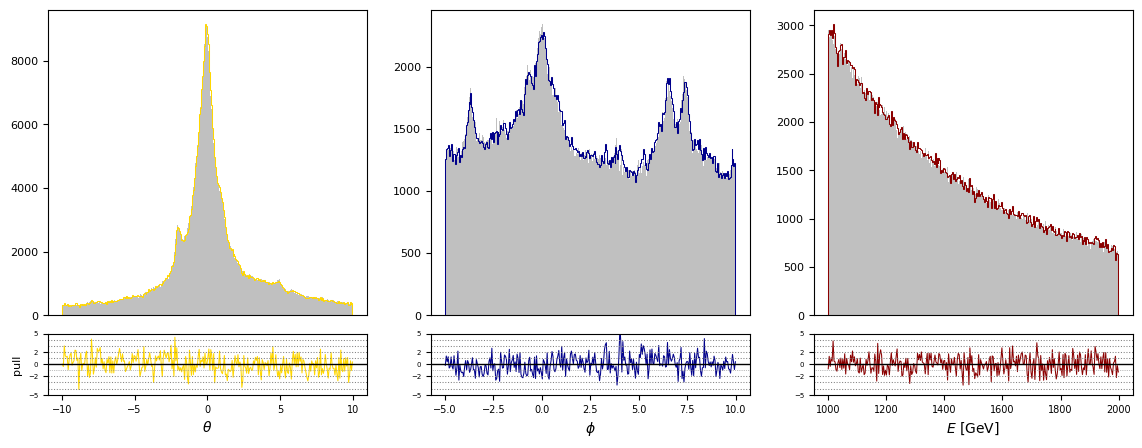

In [4]:
from utils import results_plots

results_plots(data=fermi.target, 
              generated=pretrained_pipeline.target, 
              comparator='pull',
              save_dir=configs.workdir, 
              bins=300, 
              features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'])

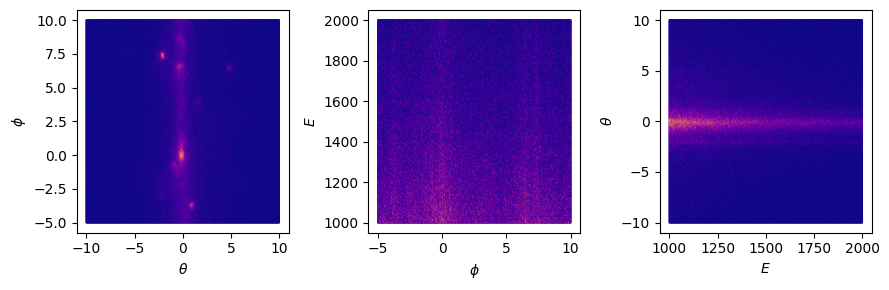

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(pretrained_pipeline.target[..., i], pretrained_pipeline.target[..., j], cmap='plasma', gridsize=500)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.savefig(configs.workdir + '/fermi_features_2D.pdf')
plt.show()